In [168]:
import pandas as pd
import os

def filter_csv_by_existing_files(csv_path, base_data_dir, output_path):
    df = pd.read_csv(csv_path)
    def file_exists(rel_path):
        full_path = os.path.join(base_data_dir, rel_path.strip())
        return os.path.isfile(full_path)
    filtered_df = df[df['Path'].apply(file_exists)]
    print(f"Filtered {csv_path}:")
    print(f"  Original rows: {len(df)}")
    print(f"  Rows with existing files: {len(filtered_df)}")
    filtered_df.to_csv(output_path, index=False)

# Replace 'data' below with your actual data directory path (without trailing slash)
base_dir = '/Users/apple/Desktop/SignSpotter/data'  
train_csv = os.path.join(base_dir, 'Train.csv')
test_csv = os.path.join(base_dir, 'Test.csv')

filter_csv_by_existing_files(train_csv, base_dir, os.path.join(base_dir, 'Train_filtered.csv'))
filter_csv_by_existing_files(test_csv, base_dir, os.path.join(base_dir, 'Test_filtered.csv'))


Filtered /Users/apple/Desktop/SignSpotter/data/Train.csv:
  Original rows: 39209
  Rows with existing files: 39209
Filtered /Users/apple/Desktop/SignSpotter/data/Test.csv:
  Original rows: 12630
  Rows with existing files: 12630


In [169]:
import matplotlib.pyplot as plt

In [170]:
import cv2

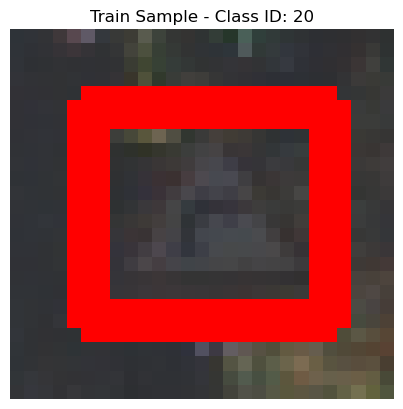

In [171]:
def show_sample(df, dataset_type = 'Train', index=0):
    row = df.iloc[index]
    img_path = os.path.join(dataset_dir, row['Path'])

    img = cv2.imread(img_path)
    if img is None:
        print(f"[!] Image not found or cannot be read: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Rectangular box indicating the Region of Interest
    x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
    class_id = row['ClassId']
    cv2.rectangle(img, (x1,y1), (x2,y2), color=(255, 0, 0), thickness = 2)
    plt.imshow(img)
    plt.title(f"{dataset_type} Sample - Class ID: {class_id}")
    plt.axis('off')
    plt.show()


dataset_dir = '/Users/apple/Desktop/SignSpotter/data'
filtered_train_df = pd.read_csv(os.path.join(dataset_dir, 'Train_filtered.csv'))

#Show sample image from Train set
for i in range(1):
    show_sample(filtered_train_df, dataset_type = 'Train', index=i)                                                              



    

In [172]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [173]:
class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None, use_roi=False):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        self.use_roi = use_roi

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.data_dir, row['Path'])
        image = Image.open(img_path).convert("RGB")  # Use PIL for transforms

        if self.use_roi:
            x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
            image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        label = row['ClassId']
        return image, label


In [174]:
from torchvision import transforms

# Define image transforms (resize to 32x32 and normalize to [-1, 1])
transform = transforms.Compose([
    transforms.Resize((32, 32)),           # Resize image to 32x32
    transforms.ToTensor(),                 # Convert to PyTorch tensor (C x H x W)
    transforms.Normalize((0.5,), (0.5,))   # Normalize RGB values to [-1, 1]
])


In [175]:
csv_file = '/Users/apple/Desktop/SignSpotter/data/Train_filtered.csv'
data_dir = '/Users/apple/Desktop/SignSpotter/data'

# Create dataset
train_dataset = TrafficSignDataset(csv_file=csv_file, data_dir=data_dir, transform=transform, use_roi=True)


In [176]:
from torchvision.utils import make_grid
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

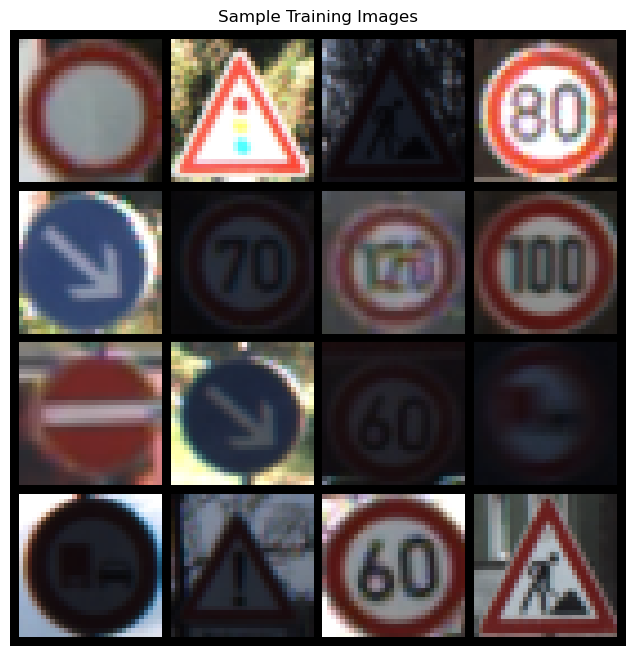

In [177]:
images, labels = next(iter(train_loader))
images = images * 0.5 + 0.5 
grid = make_grid(images, nrow = 4)
plt.figure(figsize = (8,8))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Training Images")
plt.axis('off')
plt.show()

In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

#Defining CNN model
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes = 43):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


Using device: mps


In [179]:
#Initialising Model
model = TrafficSignCNN(num_classes=43).to(device)
print("Model device:", next(model.parameters()).device)

Model device: mps:0


In [180]:
import torch.optim as optim
num_epochs = 10
learning_rate = 0.001
model = TrafficSignCNN(num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()       
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [181]:
from sklearn.model_selection import train_test_split

csv_file = '/Users/apple/Desktop/SignSpotter/data/Train_filtered.csv'
data_dir = '/Users/apple/Desktop/SignSpotter/data'

# Load the full dataframe
df = pd.read_csv(csv_file)

# Split into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClassId'], random_state=42)

# Save temporary CSVs (optional, for reuse)
train_df.to_csv(os.path.join(data_dir, 'Train_split.csv'), index=False)
val_df.to_csv(os.path.join(data_dir, 'Val_split.csv'), index=False)


In [194]:
train_dataset = TrafficSignDataset(
    csv_file = os.path.join(data_dir, 'Train_split.csv'),
    data_dir = data_dir,
    transform = transform,
    use_roi = True
)

val_dataset = TrafficSignDataset(
    csv_file = os.path.join(data_dir, 'Val_split.csv'),
    data_dir = data_dir,
    transform = transform,
    use_roi = True
)

test_csv = os.path.join(data_dir, "Test.csv")
test_dataset = TrafficSignDataset(
    csv_file=test_csv,
    data_dir=data_dir,
    transform=transform,
    use_roi=True
)


train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [183]:
def calculate_accuracy(outputs,labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

In [184]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0  # keep this outside the epoch loop

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        # ----- Training Loop -----
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total

        # ----- Validation Loop -----
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects / val_total

        # ----- Save Best Model -----
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_signspotter_model.pth")

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


In [185]:
print(len(train_loader.dataset), len(val_loader.dataset))
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

31367 7842
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [186]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

Epoch [1/10] Train Loss: 1.6244 | Train Acc: 0.5297 Val Loss: 0.3673 | Val Acc: 0.9172
Epoch [2/10] Train Loss: 0.5423 | Train Acc: 0.8287 Val Loss: 0.1699 | Val Acc: 0.9575
Epoch [3/10] Train Loss: 0.3698 | Train Acc: 0.8822 Val Loss: 0.1067 | Val Acc: 0.9805
Epoch [4/10] Train Loss: 0.2938 | Train Acc: 0.9082 Val Loss: 0.0773 | Val Acc: 0.9846
Epoch [5/10] Train Loss: 0.2388 | Train Acc: 0.9236 Val Loss: 0.0615 | Val Acc: 0.9862
Epoch [6/10] Train Loss: 0.2171 | Train Acc: 0.9322 Val Loss: 0.0576 | Val Acc: 0.9879
Epoch [7/10] Train Loss: 0.1818 | Train Acc: 0.9402 Val Loss: 0.0570 | Val Acc: 0.9893
Epoch [8/10] Train Loss: 0.1664 | Train Acc: 0.9459 Val Loss: 0.0449 | Val Acc: 0.9888
Epoch [9/10] Train Loss: 0.1504 | Train Acc: 0.9520 Val Loss: 0.0473 | Val Acc: 0.9912
Epoch [10/10] Train Loss: 0.1384 | Train Acc: 0.9548 Val Loss: 0.0366 | Val Acc: 0.9926


Test Loss: 0.1369 | Test Acc: 0.9661


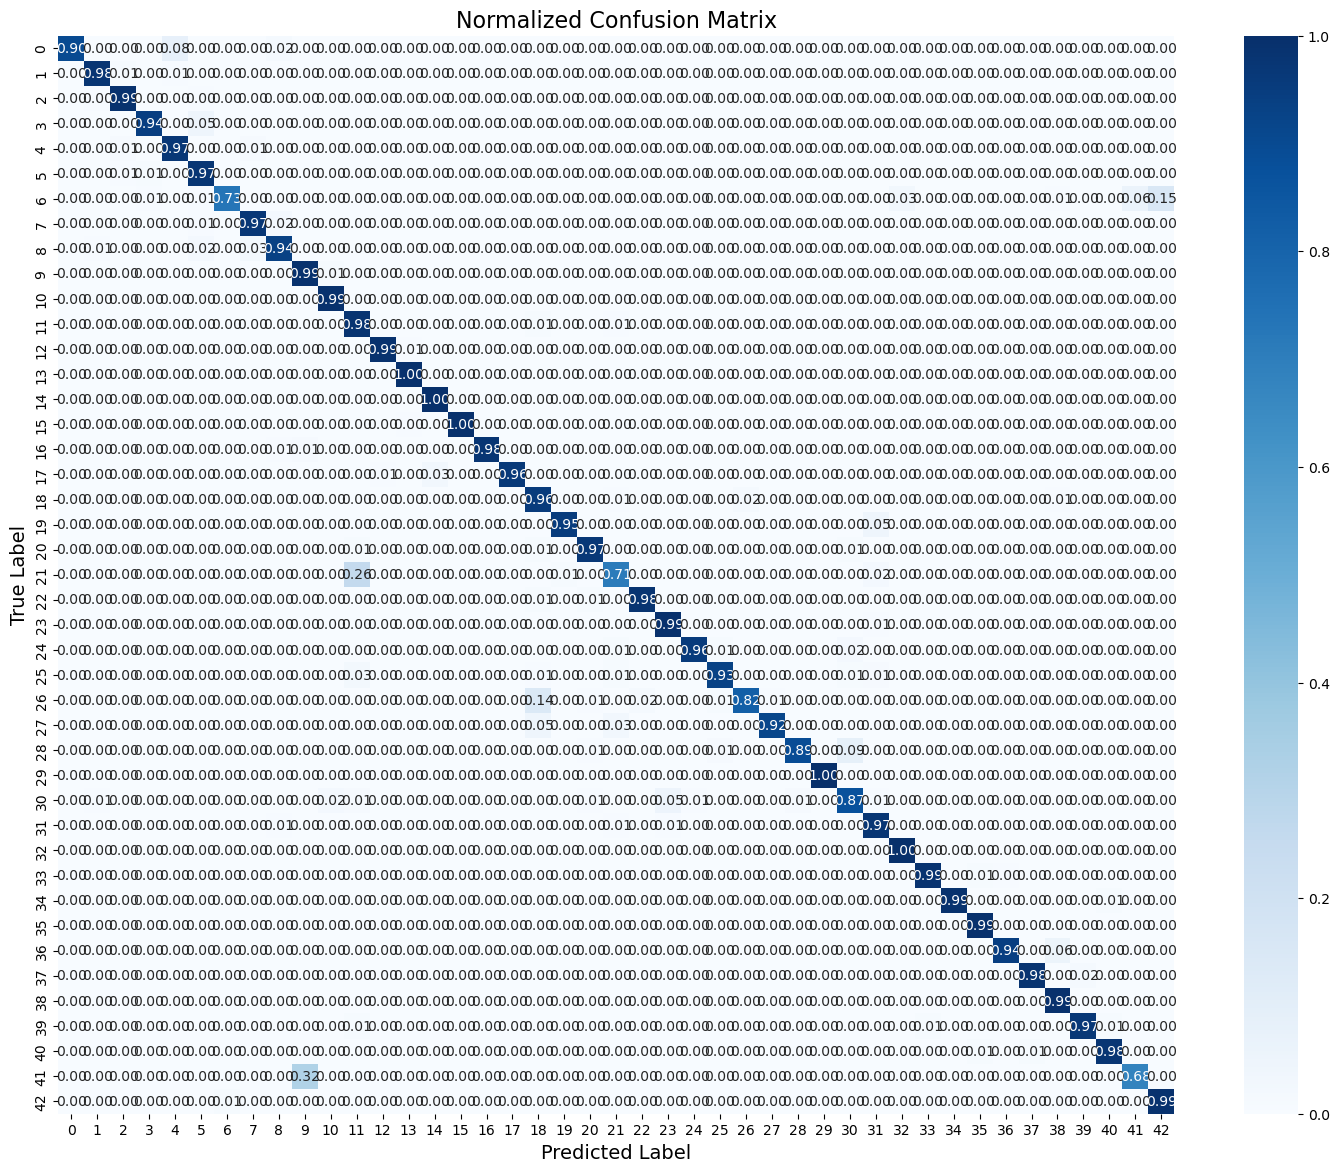

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        60
           1       0.98      0.98      0.98       720
           2       0.97      0.99      0.98       750
           3       0.98      0.94      0.96       450
           4       0.98      0.97      0.98       660
           5       0.94      0.97      0.95       630
           6       0.99      0.73      0.84       150
           7       0.95      0.97      0.96       450
           8       0.97      0.94      0.95       450
           9       0.95      0.99      0.97       480
          10       0.98      0.99      0.99       660
          11       0.91      0.98      0.94       420
          12       1.00      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       0.96      1.00      0.98       270
          15       0.99      1.00      0.99       210
          16       1.00      0.98      0.99       150
    

In [200]:
#Model Evaluation

num_classes = 43

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model = TrafficSignCNN(num_classes).to(device)
best_model.load_state_dict(torch.load("best_signspotter_model.pth"))
best_model.eval()

test_loss, test_corrects, test_total = 0.0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs,1)
        test_corrects += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= test_total
test_acc = test_corrects / test_total

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

#CONFUSION MATRIX
cm = confusion_matrix(all_labels, all_preds)

# Normalizing
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(18, 14))  # Bigger figure for clarity
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True)

plt.title("Normalized Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

#Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

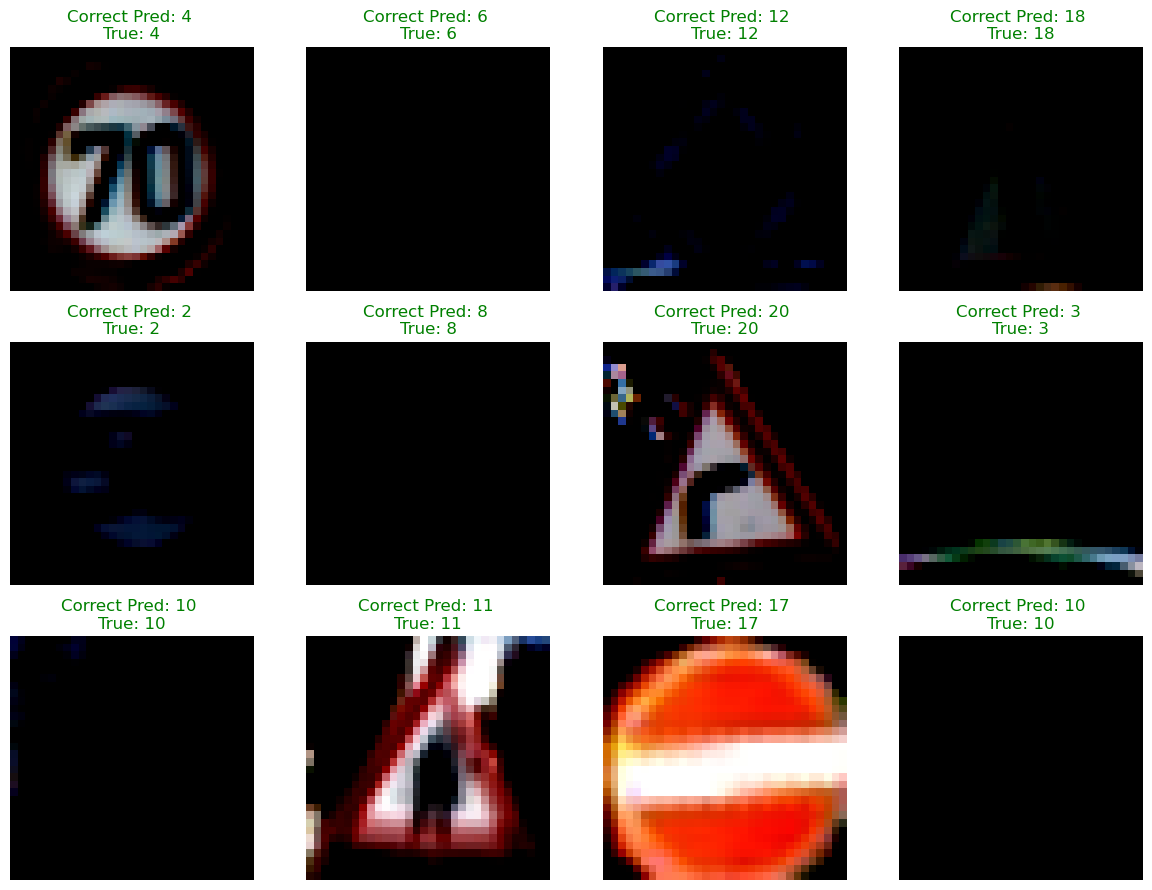

Model saved to signspotter_cnn.pth


In [217]:
import random
import matplotlib.pyplot as plt

num_samples = 12
indices = random.sample(range(len(test_dataset)), num_samples)

best_model.eval()
fig, axes = plt.subplots(3,4, figsize = (12, 9))
axes = axes.flatten()

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = best_model(image_input)
        pred_label = output.argmax(1).item()

    img = image.permute(1,2,0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].axis("off")
    if pred_label == true_label:
        axes[i].set_title(f"Correct Pred: {pred_label} \nTrue: {true_label}", color = "green")
    else:
        axes[i].set_title(f"Wrong Pred: {pred_label} \n True: {true_label}", color = "red")
plt.tight_layout()
plt.show()

#SAVING THE MODEL
MODEL_PATH = "signspotter_cnn.pth"
torch.save(best_model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

In [279]:
#RELOAD THE MODEL
loaded_model = TrafficSignCNN(num_classes).to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

print(f"Model loaded and ready for inference")

Model loaded and ready for inference


In [281]:
class_id_to_name = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 tons",
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 tons"
}


In [337]:
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load your test CSV once at the top
test_csv_path = "/Users/apple/Desktop/SignSpotter/data/Test.csv"   # or Test_filtered.csv
df_test = pd.read_csv(test_csv_path)

def predict_image(image_path, model, transform, device=None, df=None, data_dir="/Users/apple/Desktop/SignSpotter/data"):
    # Auto-detect device if not provided
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else "cpu"
    
    # Put model on correct device
    model = model.to(device)
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)
    
    predicted_class = preds.item()
    predicted_name = class_id_to_name[predicted_class]

    # üîπ Lookup true label from CSV if available
    true_label, true_name = None, None
    if df is not None:
        rel_path = os.path.relpath(image_path, data_dir).replace("\\", "/")
        row = df[df["Path"].str.replace("\\", "/") == rel_path]
        if not row.empty:
            true_label = int(row["ClassId"].values[0])
            true_name = class_id_to_name[true_label]

    # Show result
    plt.imshow(image)
    title = f"Predicted: {predicted_name}"
    if true_name is not None:
        title += f"\nTrue: {true_name}"
    plt.title(title, fontsize=12, color="green" if predicted_class == true_label else "red")
    plt.axis("off")
    plt.show()
    

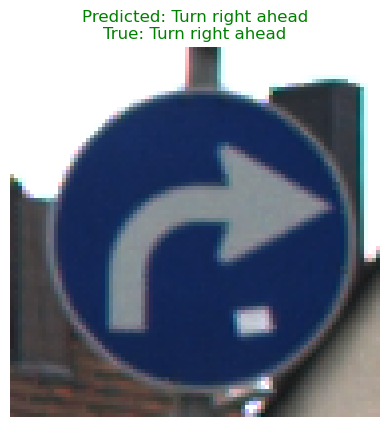

In [339]:
img_path = "/Users/apple/Desktop/SignSpotter/data/Test/00234.png"

predict_image(
    img_path,
    model,
    transform,
    device="cpu",
    df=df_test,
    data_dir="/Users/apple/Desktop/SignSpotter/data"
)


In [341]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- STEP 1: Random Sample Predictions ---
def predict_random_samples(model, transform, df, data_dir, n=10, device="cpu"):
    sample_df = df.sample(n=n).reset_index(drop=True)
    
    for i in range(n):
        img_path = os.path.join(data_dir, sample_df.loc[i, "Path"])
        true_label = int(sample_df.loc[i, "ClassId"])
        
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Predict
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            _, preds = torch.max(outputs, 1)
        
        predicted_class = preds.item()
        predicted_name = class_id_to_name[predicted_class]
        true_name = class_id_to_name[true_label]
        
        # Show result
        plt.imshow(image)
        if predicted_class == true_label:
            plt.title(f"‚úÖ Predicted: {predicted_name}\nTrue: {true_name}", color="green")
        else:
            plt.title(f"‚ùå Predicted: {predicted_name}\nTrue: {true_name}", color="red")
        plt.axis("off")
        plt.show()


# --- STEP 2: Evaluate Full Test Set ---
def evaluate_model(model, transform, df, data_dir, device="cpu"):
    correct = 0
    total = len(df)
    
    model = model.to(device)
    model.eval()
    
    for i in range(total):
        img_path = os.path.join(data_dir, df.loc[i, "Path"])
        true_label = int(df.loc[i, "ClassId"])
        
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            _, preds = torch.max(outputs, 1)
        
        pred_class = preds.item()
        
        if pred_class == true_label:
            correct += 1
    
    accuracy = 100 * correct / total
    print(f" Test Accuracy: {accuracy:.2f}% ({correct}/{total})")
    return accuracy


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


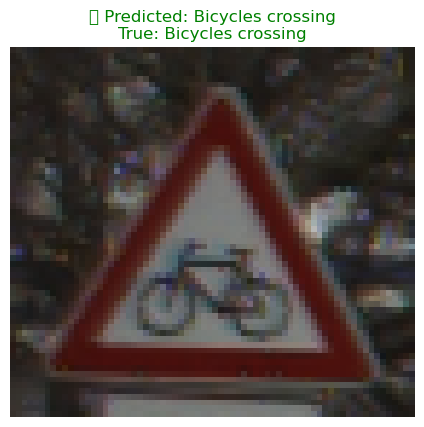

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


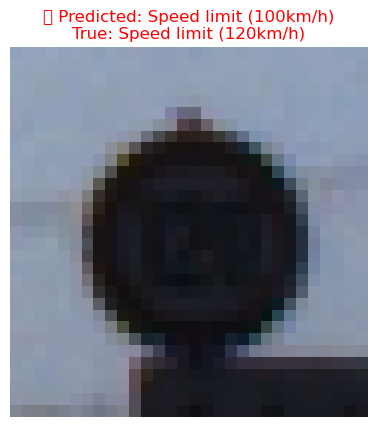

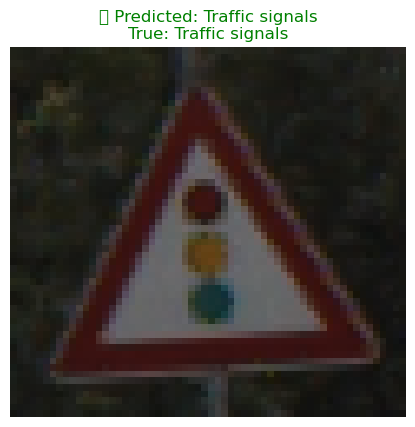

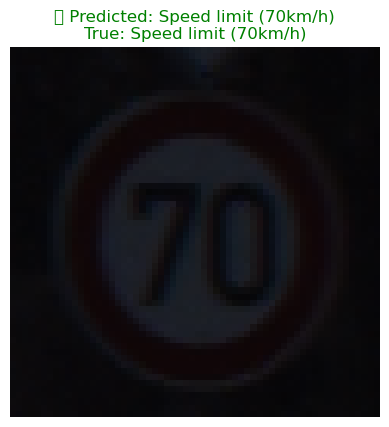

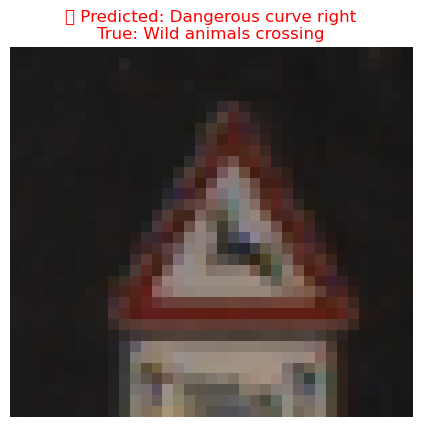

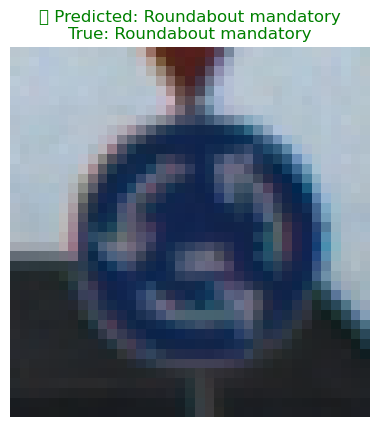

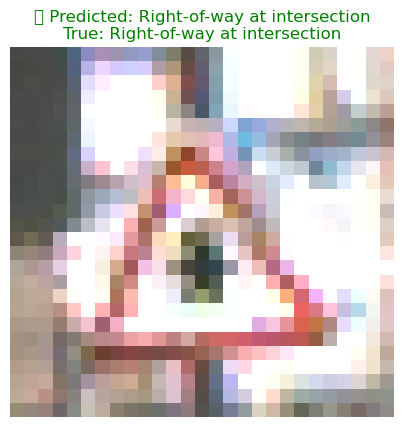

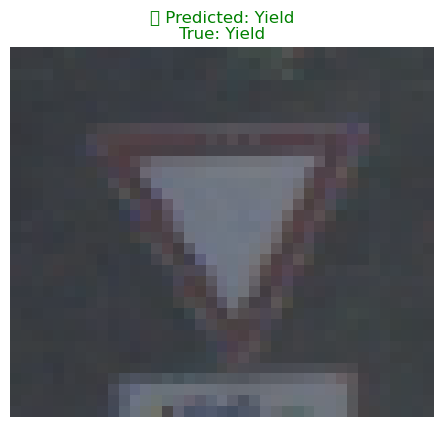

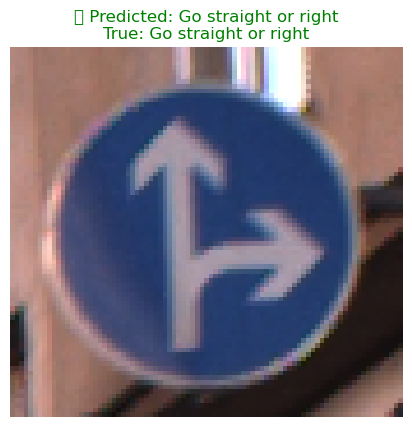

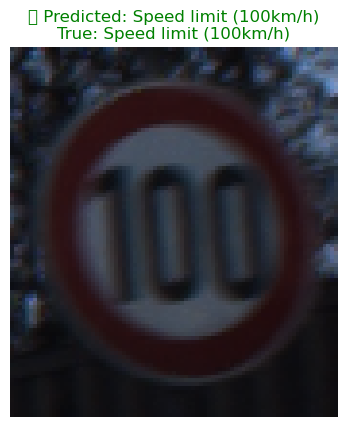

In [343]:
# Step 1: See random predictions
predict_random_samples(model, transform, df_test, "/Users/apple/Desktop/SignSpotter/data", n=10, device="cpu")



In [345]:
# Step 2: Compute accuracy
evaluate_model(model, transform, df_test, "/Users/apple/Desktop/SignSpotter/data", device="cpu")

 Test Accuracy: 77.55% (9795/12630)


77.55344418052256

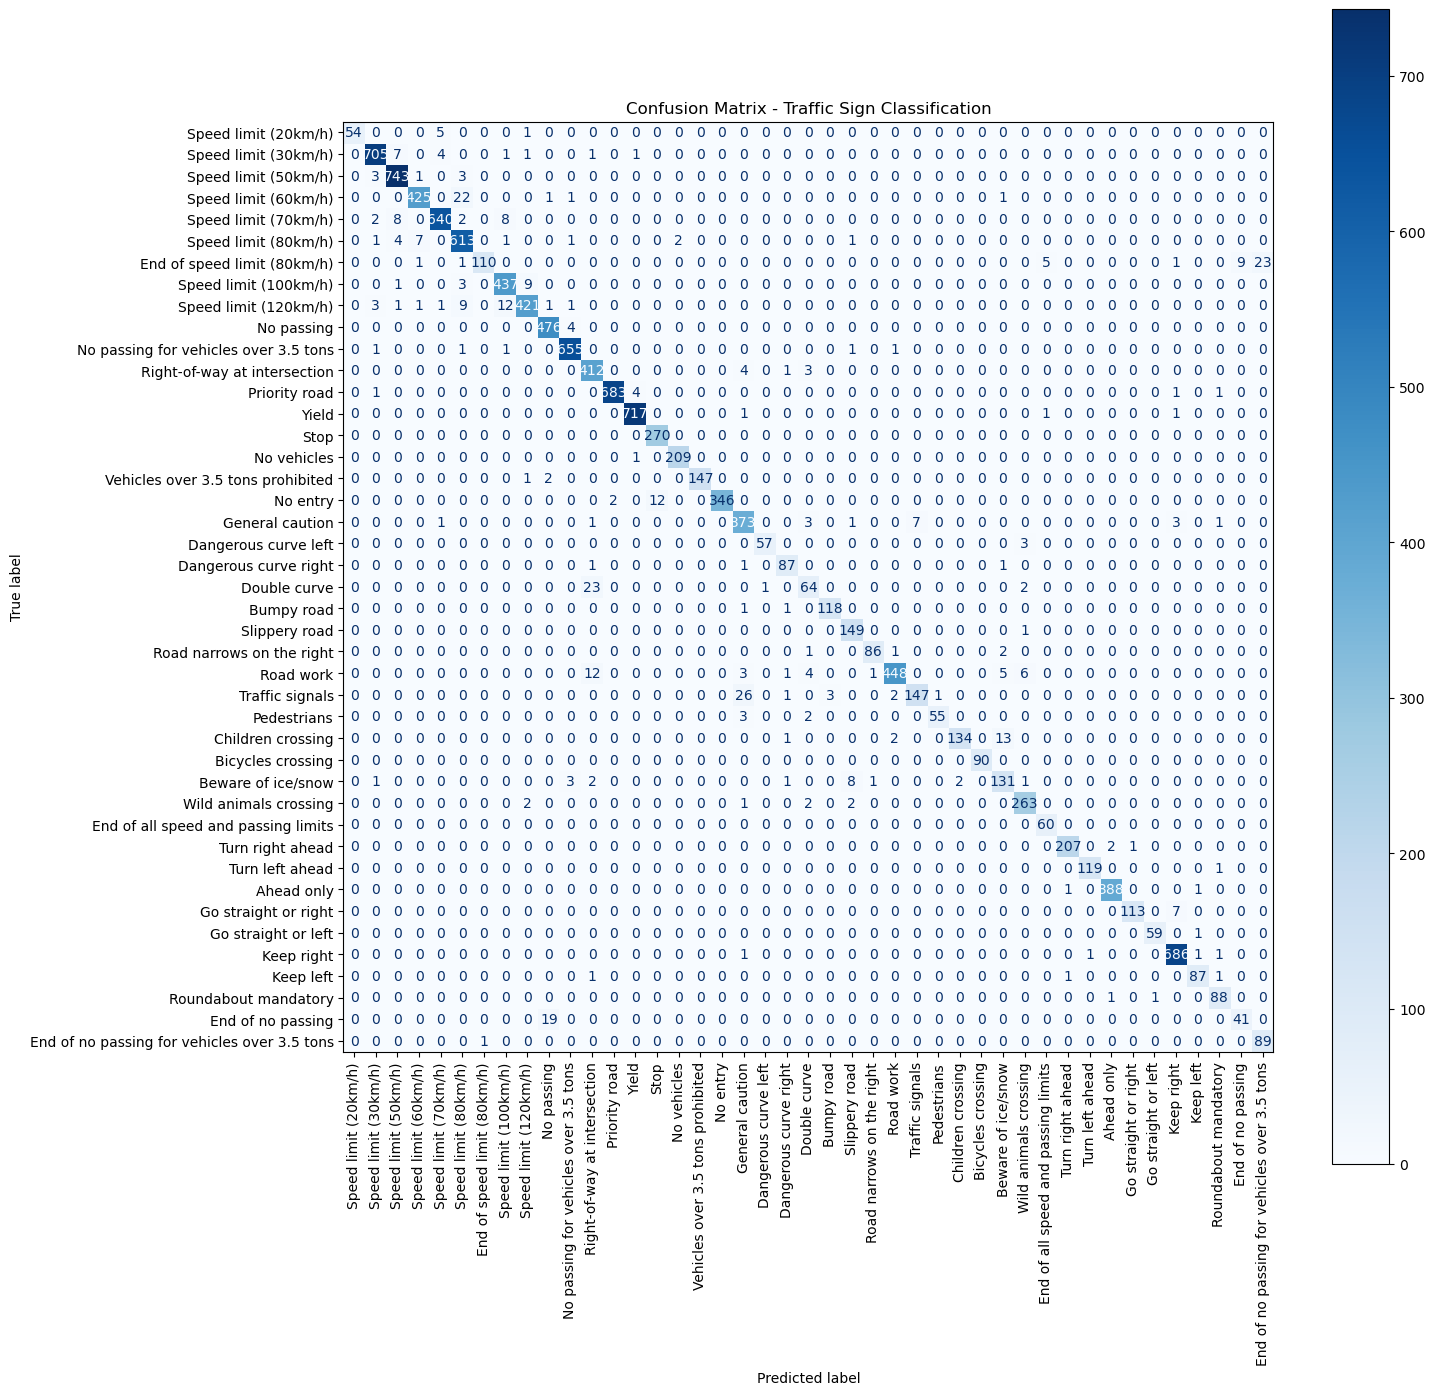

In [347]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Put model in eval mode
model.eval()

# Get all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cpu"), labels.to("cpu")
        model = model.to("cpu")
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it (with labels)
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_id_to_name[i] for i in range(len(class_id_to_name))])
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format="d")
plt.title("Confusion Matrix - Traffic Sign Classification")
plt.show()


In [349]:
# Helper: unnormalize for plotting
def imshow(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    img = std * img + mean  # reverse normalization
    img = np.clip(img, 0, 1)  # keep in [0,1] range
    plt.imshow(img)

def show_predictions_grid(model, test_loader, class_id_to_name, device="cpu", num_images=9):
    model.eval()
    model.to(device)

    images, labels = next(iter(test_loader))
    idxs = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(idxs):
        img = images[idx].unsqueeze(0).to(device)
        true_label = labels[idx].item()

        with torch.no_grad():
            outputs = model(img)
            _, pred = torch.max(outputs, 1)
            predicted_class = pred.item()

        predicted_name = class_id_to_name[predicted_class]
        true_name = class_id_to_name[true_label]

        plt.subplot(int(num_images**0.5), int(num_images**0.5), i+1)
        imshow(images[idx])  # <- FIXED here
        plt.axis("off")

        color = "green" if predicted_class == true_label else "red"
        plt.title(f"Pred: {predicted_name}\nTrue: {true_name}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()


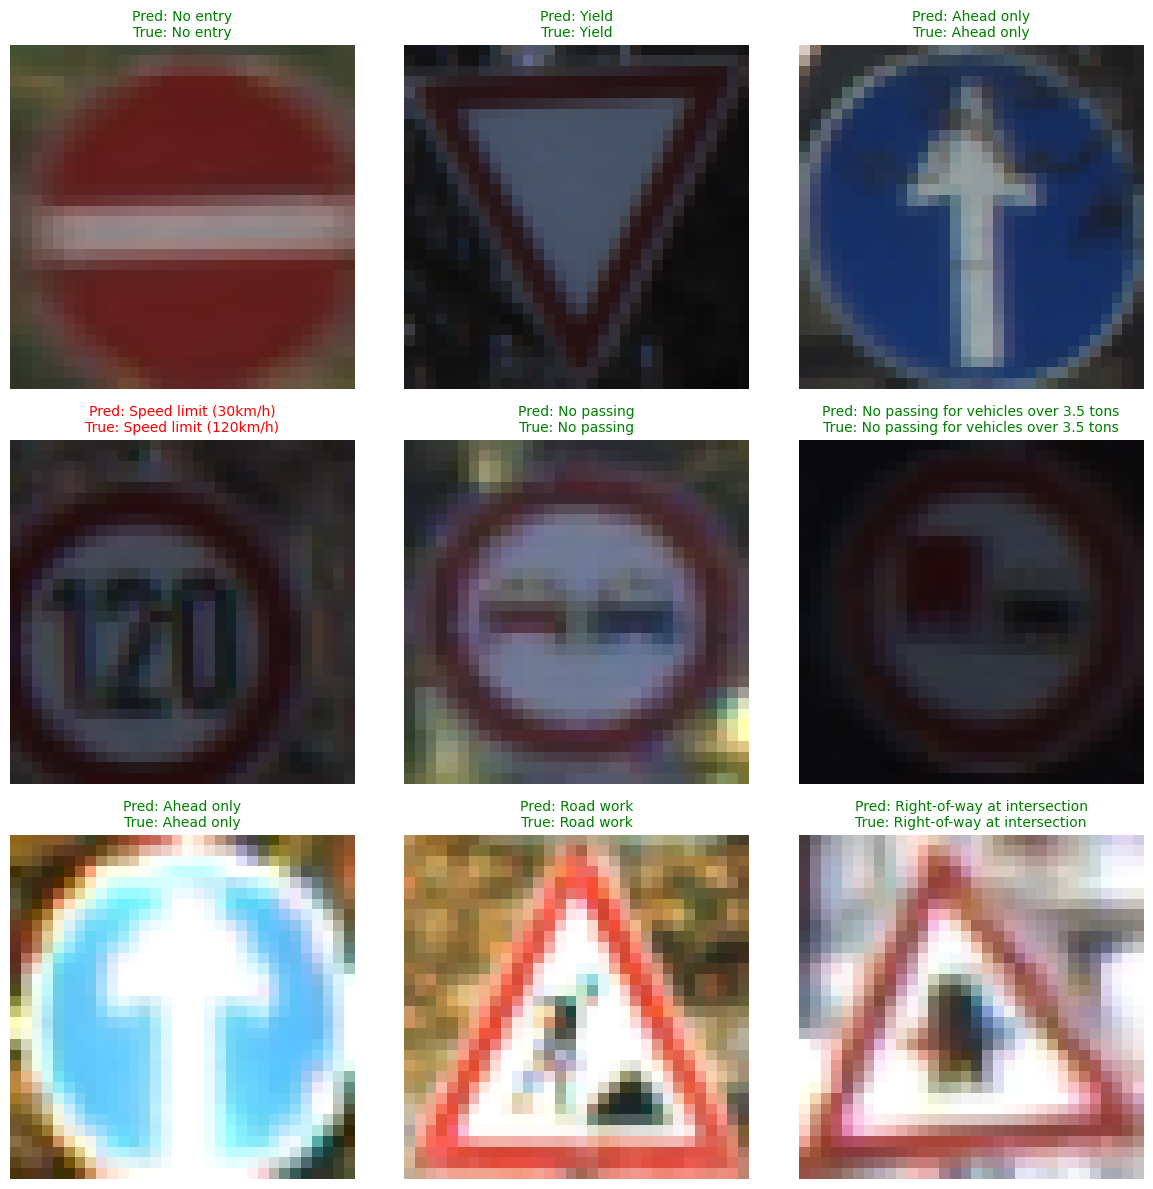

In [351]:
show_predictions_grid(model, test_loader, class_id_to_name, device="cpu", num_images=9)